# PyTorch Tutorial, Loading and saving model (LeNet):
#### We define and train LeNet with the MNIST data, and then save the trained model
- Download the **MNIST** dataset
- Define a **LeNet** (model)
- Define loss function **MSE**  and optimizer as **SGD**
- Train the LeNet and evaluate it
- Save the LeNet parameters with **torch.save()** and load them with **torch.load()**
- Save the entire LeNet model with *torch.save()* and load with *torch.load()*

**Hint:** In previous post, we learned how to train a model with the MNIST dataset. This time, we use the LeNet model for the classification of handwritten digits.

https://github.com/ostad-ai/PyTorch-Tutorial

In [39]:
# importing the necessary modules
import torch
import torch.nn as tnn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda,Resize,Compose
from matplotlib import pyplot as plt

As we did before we download the MINST data set

In [2]:
training_set=datasets.MNIST(root='./MNIST',train=True, download=True, transform=ToTensor())
test_set=datasets.MNIST(root='./MNIST',train=False,download=True,transform=ToTensor())

Resize the input images of size 28-by-28 to size **32-by-32**, because the original **LeNet** gets images of size 32-by-32.

In [45]:
image_resize_transform=Compose([Resize(size=(32,32)),ToTensor()])
training_set.transform=image_resize_transform
test_set.transform=image_resize_transform

Converting the class labels to one-hot vectors

In [46]:
one_hot_transform=Lambda(lambda y:torch.zeros(Nclasses,dtype=torch.float).index_put([torch.tensor(y)],
                                                                         values=torch.tensor(1.)))
training_set.target_transform=one_hot_transform
test_set.target_transform=one_hot_transform

Using **DataLoader** to make dataset iterable and in a form of batches

In [47]:
batchSize=16
train_dataloader=DataLoader(training_set,batch_size=batchSize,shuffle=True)
test_dataloader=DataLoader(test_set,batch_size=batchSize,shuffle=True)

In [48]:
device=torch.device('cuda' if torch.cuda.is_available()
         else 'mps' if torch.backends.mps.is_available()
         else 'cpu')
print(f'The device chosen is: {device}')

The device chosen is: cuda


Defining the **Lenet** model, and set the device of model:

In [54]:
cin,Nclasses=1,10
model=tnn.Sequential(
      tnn.Conv2d(cin,6,kernel_size=5),
      tnn.ReLU(),
      tnn.MaxPool2d(kernel_size=2,stride=2),
      tnn.Conv2d(6,16,kernel_size=5),
      tnn.ReLU(),
      tnn.MaxPool2d(kernel_size=2,stride=2),
      tnn.Flatten(),
      tnn.Linear(16*5*5,120), #16*5*5=400
      tnn.ReLU(),
      tnn.Linear(120,84),
      tnn.ReLU(),
      tnn.Linear(84,Nclasses)      
)
model=model.to(device)

Choose the loss function and optimizer:
 - Loss function is **Mean Squared Error** (MSE)
 - The optimzier is **Stochastic Gradient Descent** (SGD)

In [55]:
learningRate=.001 # this is the learning rate in the SGD algorithm
optimizer=torch.optim.SGD(model.parameters(),lr=learningRate)
lossFn=tnn.MSELoss().to(device)

We train the model with the training set.
<br>Each run over the whole training set is called an **epoch**. We train the model over several epochs.

In [56]:
Nepochs=30
loss_epochs=[]
model.train()
for i in range(Nepochs):
    losses=0.
    for x,y in train_dataloader:
        x,y=x.to(device),y.to(device)
        output=model(x)
        loss=lossFn(output,y)
        losses+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch{i}, loss:{losses}', end='; ')
    loss_epochs.append(losses)

Epoch0, loss:349.38851753622293; Epoch1, loss:337.70612182468176; Epoch2, loss:335.6845654696226; Epoch3, loss:334.7944259047508; Epoch4, loss:333.91106417030096; Epoch5, loss:332.830480478704; Epoch6, loss:331.4548827111721; Epoch7, loss:329.6796717569232; Epoch8, loss:327.3902518302202; Epoch9, loss:324.37757478654385; Epoch10, loss:320.28624837100506; Epoch11, loss:314.5762178003788; Epoch12, loss:306.73349337279797; Epoch13, loss:296.69125117361546; Epoch14, loss:285.1521411202848; Epoch15, loss:272.75507967174053; Epoch16, loss:259.2937738597393; Epoch17, loss:244.70307748019695; Epoch18, loss:229.1961415298283; Epoch19, loss:213.2877288274467; Epoch20, loss:198.28081243112683; Epoch21, loss:185.34943034686148; Epoch22, loss:174.62257538549602; Epoch23, loss:165.69931664131582; Epoch24, loss:158.00047400780022; Epoch25, loss:151.15065685845912; Epoch26, loss:144.8699934706092; Epoch27, loss:139.07992906030267; Epoch28, loss:133.69492955878377; Epoch29, loss:128.66235998366028; 

At this step, we  show the curve of training loss of each epoch as epoch advances:

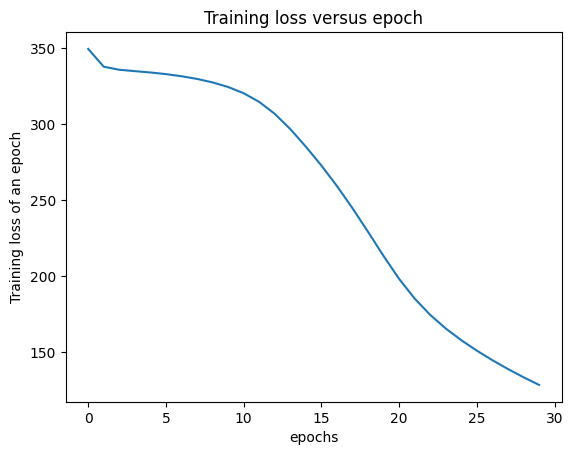

In [57]:
plt.plot(loss_epochs)
plt.title('Training loss versus epoch')
plt.xlabel('epochs')
plt.ylabel('Training loss of an epoch')
plt.show()

As we see above, during training phase, the loss value is reduced after each epoch.
<br>Let's evaluate the trained model with unseen dataset, called **test set**

In [58]:
model.eval()
test_loss=0.
accuracy=0.
#Nbatches=len(test_dataloader)
NtestSamples=len(test_dataloader.dataset)
with torch.no_grad():
    for x,y in test_dataloader:
        x,y=x.to(device),y.to(device)
        output=model(x)
        predicted=torch.argmax(output,axis=1)
        ydesired=torch.argmax(y,axis=1)
        accuracy+=(predicted==ydesired).type(torch.float).sum().item()
        loss=lossFn(output,y)
        test_loss+=loss.item()
print(f'Total test loss : {test_loss}')
print(f'Accuracy(%): {100*accuracy/NtestSamples}')

Total test loss : 20.583334581926465
Accuracy(%): 88.52


Now, we actually give a batch of test images to the model, and observe the predicted labels. 
<br>We compare the predicated labels with the true labels.

The accuracy of a test batch (%): 93.75


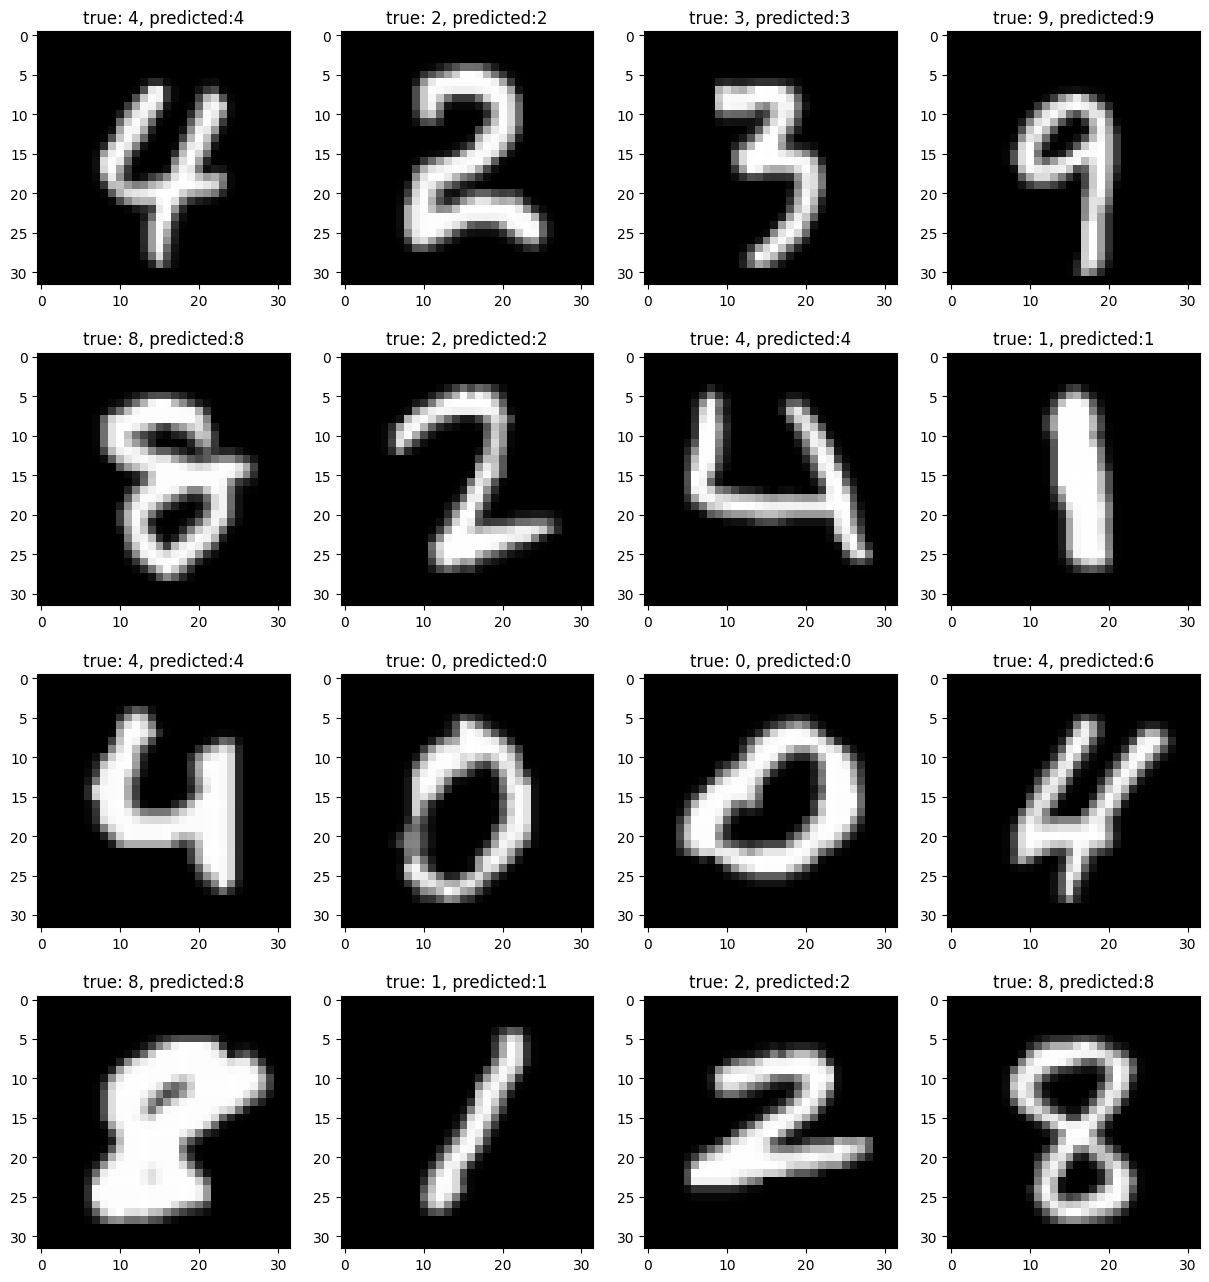

In [61]:
accuracy_batch=0.
model.eval()
with torch.no_grad():
    x,y=next(iter(test_dataloader))
    x,y=x.to(device),y.to(device)
    output=model(x)
    y=y.argmax(1)
    predicted=output.argmax(1)
    accuracy_batch+=(y==predicted).type(torch.float).sum().item()
    accuracy_batch/=batchSize
    print(f'The accuracy of a test batch (%): {100*accuracy_batch}')
    #plt.title(f'correct number is: {true_label.item()}, predicted number: {predicted_label}')
plt.figure(figsize=(15,16))
for i in range(batchSize):
    plt.subplot(4,4,i+1)
    plt.title(f'true: {y[i].item()}, predicted:{predicted[i].item()}')
    plt.imshow(x[i].cpu().numpy()[0],cmap='gray')
plt.show()

Let's save the model weights or load them. The model parameters are in internal state dictionary. This state dictionary is part of the model object, named **state_dict**.
<br> For saving a model, we use **torch.save()**

In [71]:
# saving the trained model parameters
modelPath='./MNIST/mylenet.pth'
torch.save(model.state_dict(),modelPath)

We can load the model parameters from the saved dictionary state with **torch.load()** as shown below:
 - Hint: For this purpose, we need an instance of the model

In [72]:
model_to_load=tnn.Sequential(
      tnn.Conv2d(cin,6,kernel_size=5),
      tnn.ReLU(),
      tnn.MaxPool2d(kernel_size=2,stride=2),
      tnn.Conv2d(6,16,kernel_size=5),
      tnn.ReLU(),
      tnn.MaxPool2d(kernel_size=2,stride=2),
      tnn.Flatten(),
      tnn.Linear(16*5*5,120), #16*5*5=400
      tnn.ReLU(),
      tnn.Linear(120,84),
      tnn.ReLU(),
      tnn.Linear(84,Nclasses)      
)
model_to_load.load_state_dict(torch.load(modelPath))

<All keys matched successfully>

Another way to load and save models is to save the entire model, and then load the entire model as shown below:

In [75]:
modelPathEntire='./MNIST/mylenetentire.pth'
# saving the entire model
torch.save(model,modelPathEntire)
# loading the entire model
model_entire=torch.load(modelPathEntire)
# let's print the loaded model
print(model_entire)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)
